 # 导入包

In [1]:
import torch
import numpy as np
import random
from torch.utils.data import  Dataset
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 全局变量

In [2]:
batch_size=512
lr  = 0.01
epoch_num = 20
num_workers=0

# 构造数据集

In [3]:
random.seed(42)
torch.manual_seed(42)
class MultiDataSet(Dataset):
    def __init__(self, root, train=True, transform=None, download=True):
        self.mnist = torchvision.datasets.MNIST(root=root, train=train, download=download, transform=transform)
        self.targets = torch.eye(10)[self.mnist.targets]

    def __getitem__(self, index):
        image, target = self.mnist[index]
        processed_target = self.targets[index]
        return image, processed_target, target

    def __len__(self):
        return len(self.mnist)

mnist_train = MultiDataSet(root='E:/毕设文件/DeepLearning/experiment01/Datasets/MNIST', train=True,
                                    download=True, transform=transforms.ToTensor())
mnist_test = MultiDataSet(root='E:/毕设文件/DeepLearning/experiment01/Datasets/MNIST', train=False,
                                   download=True, transform=transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True,num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False,num_workers=num_workers)

# 自定义DropOut层


In [4]:
class DropoutLayer(torch.nn.Module):
    def __init__(self, p=0.5):
        super(DropoutLayer, self).__init__()
        self.p = p

    def forward(self, x):
        if self.training:

            mask = torch.rand_like(x) > self.p

            x = x * mask / (1 - self.p)
        return x

# 定义激活函数 定义网络结构 定义网络初始化参数
# 定义损失函数 定义优化器

In [5]:
inputs = 784
hiddens = 512
out = 10


class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(inputs,hiddens)
        self.relu = torch.nn.ReLU()
        self.hidden = torch.nn.Linear(hiddens,out)
        self.softmax = torch.nn.Softmax(dim=1)
    def forward(self,x):
        x = x.view(x.size(0), -1)
        t = self.linear(x)
        t = self.relu(t)
        t = self.hidden(t)
        t = self.softmax (t)
        return  t

class Net1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(inputs,hiddens)
        self.relu = torch.nn.ReLU()
        self.dropout = DropoutLayer(0.1)
        self.hidden = torch.nn.Linear(hiddens,out)
        self.softmax = torch.nn.Softmax(dim=1)
    def forward(self,x):
        x = x.view(x.size(0), -1)
        t = self.linear(x)
        t = self.relu(t)
        t = self.dropout(t)
        t = self.hidden(t)
        t = self.softmax (t)
        return  t

class Net2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(inputs,hiddens)
        self.relu = torch.nn.ReLU()
        self.dropout = DropoutLayer(0.5)
        self.hidden = torch.nn.Linear(hiddens,out)
        self.softmax = torch.nn.Softmax(dim=1)
    def forward(self,x):
        x = x.view(x.size(0), -1)
        t = self.linear(x)
        t = self.relu(t)
        t = self.dropout(t)
        t = self.hidden(t)
        t = self.softmax (t)
        return  t


loss =  torch.nn.CrossEntropyLoss()


# dropout = 0 模型训练与评估

In [6]:
import time

train_loss_0 =[]
test_loss_0 = []
train_acc_0=[]
test_acc_0= []
start_time = time.time()
net0 = Net().to(device)
opt0 = torch.optim.Adam(params=net0.parameters(),lr=lr)
for epoch in range(epoch_num):
    loss_list=[]
    acc_list=[]
    for data in train_iter:

        x, y, index =data
        if x.shape[0]<batch_size:
            continue
        y_hat = net0(x.to(device))
        l = loss(y_hat,y.to(device))
        opt0.zero_grad()
        l.backward()
        opt0.step()
        y_index = torch.argmax(y_hat, dim=1)
        loss_list.append(l.item())
        acc = 0
        for i in range(len(y_index)):
            if y_index[i] == index[i]:
                acc += 1
        acc_list.append(acc/len(y_index))

    train_loss_mean = np.mean(loss_list)
    train_acc_mean = np.mean(acc_list)
    train_loss_0.append(train_loss_mean)
    train_acc_0.append(train_acc_mean)
    loss_list=[]
    acc_list=[]
    for data in test_iter:
        x, y, index =data
        if x.shape[0]<batch_size:
            continue
        y_hat = net0(x.to(device))
        l = loss(y_hat,y.to(device))
        loss_list.append(l.item())
        y_index = torch.argmax(y_hat, dim=1)
        acc = 0
        for i in range(len(y_index)):
            if y_index[i] == index[i]:
                acc += 1
        acc_list.append(acc/len(y_index))


    test_loss_mean = np.mean(loss_list)
    test_acc_mean = np.mean(acc_list)
    test_loss_0.append(test_loss_mean)
    test_acc_0.append(test_acc_mean)
    print("epoch:",epoch+1,"\n",
          "train_loss:",train_loss_mean,"train_acc:",train_acc_mean,
          "\n",
          "test_loss:",test_loss_mean,"test_acc:",test_acc_mean
          )
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

epoch: 1 
 train_loss: 1.6850361049684703 train_acc: 0.8418135683760684 
 test_loss: 1.5538380773443925 test_acc: 0.9214638157894737
epoch: 2 
 train_loss: 1.5478577389676347 train_acc: 0.9245125534188035 
 test_loss: 1.5331439971923828 test_acc: 0.9381167763157895
epoch: 3 
 train_loss: 1.5297639808084211 train_acc: 0.9398704594017094 
 test_loss: 1.5218227599796497 test_acc: 0.9455180921052632
epoch: 4 
 train_loss: 1.5185764212893624 train_acc: 0.9495359241452992 
 test_loss: 1.5143641798119796 test_acc: 0.9509662828947368
epoch: 5 
 train_loss: 1.5106248845401993 train_acc: 0.9565638354700855 
 test_loss: 1.5087579488754272 test_acc: 0.9578536184210527
epoch: 6 
 train_loss: 1.5042180851993399 train_acc: 0.9618723290598291 
 test_loss: 1.504922433903343 test_acc: 0.960217927631579
epoch: 7 
 train_loss: 1.4997290169071948 train_acc: 0.9661458333333334 
 test_loss: 1.5013024116817273 test_acc: 0.9635074013157895
epoch: 8 
 train_loss: 1.4952891545417981 train_acc: 0.9709034455128205

# dropout = 0.1 模型训练与评估

In [7]:
import time
train_loss_1 =[]
test_loss_1 = []
train_acc_1=[]
test_acc_1= []
start_time = time.time()
net1 = Net1().to(device)
opt1 = torch.optim.Adam(params=net1.parameters(),lr=lr)
for epoch in range(epoch_num):
    loss_list=[]
    acc_list=[]
    for data in train_iter:
        x, y, index =data
        if x.shape[0]<batch_size:
            continue
        y_hat = net1(x.to(device))
        l = loss(y_hat,y.to(device))
        opt1.zero_grad()
        l.backward()
        opt1.step()

        y_index = torch.argmax(y_hat, dim=1)
        loss_list.append(l.item())
        acc = 0
        for i in range(len(y_index)):
            if y_index[i] == index[i]:
                acc += 1
        acc_list.append(acc/len(y_index))

    train_loss_mean = np.mean(loss_list)
    train_acc_mean = np.mean(acc_list)
    train_loss_1.append(train_loss_mean)
    train_acc_1.append(train_acc_mean)
    loss_list=[]
    acc_list=[]
    for data in test_iter:
        x, y, index =data
        if x.shape[0]<batch_size:
            continue
        y_hat = net1(x.to(device))
        l = loss(y_hat,y.to(device))
        loss_list.append(l.item())
        y_index = torch.argmax(y_hat, dim=1)
        acc = 0
        for i in range(len(y_index)):
            if y_index[i] == index[i]:
                acc += 1
        acc_list.append(acc/len(y_index))


    test_loss_mean = np.mean(loss_list)
    test_acc_mean = np.mean(acc_list)
    test_loss_1.append(test_loss_mean)
    test_acc_1.append(test_acc_mean)
    print("epoch:",epoch+1,"\n",
          "train_loss:",train_loss_mean,"train_acc:",train_acc_mean,
          "\n",
          "test_loss:",test_loss_mean,"test_acc:",test_acc_mean
          )
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

epoch: 1 
 train_loss: 1.6927713909719744 train_acc: 0.82421875 
 test_loss: 1.5586270846818622 test_acc: 0.9177631578947368
epoch: 2 
 train_loss: 1.5510607896706996 train_acc: 0.9225594284188035 
 test_loss: 1.5368605412934955 test_acc: 0.9331825657894737
epoch: 3 
 train_loss: 1.532931184157347 train_acc: 0.9363982371794872 
 test_loss: 1.5237683496977155 test_acc: 0.9444901315789473
epoch: 4 
 train_loss: 1.5209733074546878 train_acc: 0.9471821581196581 
 test_loss: 1.5166652390831394 test_acc: 0.9495271381578947
epoch: 5 
 train_loss: 1.5131515621120095 train_acc: 0.9536758814102564 
 test_loss: 1.5110011477219432 test_acc: 0.9541529605263158
epoch: 6 
 train_loss: 1.5068729382294874 train_acc: 0.9597188835470085 
 test_loss: 1.5058489661467702 test_acc: 0.959703947368421
epoch: 7 
 train_loss: 1.50201599414532 train_acc: 0.9638922275641025 
 test_loss: 1.5035752120770907 test_acc: 0.962171052631579
epoch: 8 
 train_loss: 1.4976951943503485 train_acc: 0.9682491987179487 
 test_los

# dropout = 0.5 模型训练与评估

In [8]:
import time

train_loss_2 =[]
test_loss_2 = []
train_acc_2=[]
test_acc_2= []
start_time = time.time()
net2 = Net2().to(device)
opt2 = torch.optim.Adam(params=net2.parameters(),lr=lr)
for epoch in range(epoch_num):
    loss_list=[]
    acc_list=[]
    for data in train_iter:
        x, y, index =data
        if x.shape[0]<batch_size:
            continue
        y_hat = net2(x.to(device))
        l = loss(y_hat,y.to(device))
        opt2.zero_grad()
        l.backward()
        opt2.step()
        y_index = torch.argmax(y_hat, dim=1)
        loss_list.append(l.item())
        acc = 0
        for i in range(len(y_index)):
            if y_index[i] == index[i]:
                acc += 1
        acc_list.append(acc/len(y_index))

    train_loss_mean = np.mean(loss_list)
    train_acc_mean = np.mean(acc_list)
    train_loss_2.append(train_loss_mean)
    train_acc_2.append(train_acc_mean)
    loss_list=[]
    acc_list=[]
    for data in test_iter:
        x, y, index =data
        if x.shape[0]<batch_size:
            continue
        y_hat = net2(x.to(device))
        l = loss(y_hat,y.to(device))

        loss_list.append(l.item())
        y_index = torch.argmax(y_hat, dim=1)
        acc = 0
        for i in range(len(y_index)):
            if y_index[i] == index[i]:
                acc += 1
        acc_list.append(acc/len(y_index))


    test_loss_mean = np.mean(loss_list)
    test_acc_mean = np.mean(acc_list)
    test_loss_2.append(test_loss_mean)
    test_acc_2.append(test_acc_mean)
    print("epoch:",epoch+1,"\n",
          "train_loss:",train_loss_mean,"train_acc:",train_acc_mean,
          "\n",
          "test_loss:",test_loss_mean,"test_acc:",test_acc_mean
          )
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

epoch: 1 
 train_loss: 1.7149176699483497 train_acc: 0.806640625 
 test_loss: 1.568963929226524 test_acc: 0.909436677631579
epoch: 2 
 train_loss: 1.5591162178251479 train_acc: 0.9157986111111112 
 test_loss: 1.5439508212240118 test_acc: 0.9272203947368421
epoch: 3 
 train_loss: 1.5394320854773889 train_acc: 0.931640625 
 test_loss: 1.532141597647416 test_acc: 0.9366776315789473
epoch: 4 
 train_loss: 1.527289667700091 train_acc: 0.9425747863247863 
 test_loss: 1.521940971675672 test_acc: 0.9453125
epoch: 5 
 train_loss: 1.5196013267223651 train_acc: 0.9486010950854701 
 test_loss: 1.515534708374425 test_acc: 0.9514802631578947
epoch: 6 
 train_loss: 1.5126107248485599 train_acc: 0.9552116720085471 
 test_loss: 1.5089838253824335 test_acc: 0.9576480263157895
epoch: 7 
 train_loss: 1.5082668493955562 train_acc: 0.9590845352564102 
 test_loss: 1.508026725367496 test_acc: 0.9592927631578947
epoch: 8 
 train_loss: 1.504508203930325 train_acc: 0.9620559561965812 
 test_loss: 1.5042974321465

# 模型评估
- dropout技术对模型性能产生了一定的影响。在dropout率为0时，模型在训练集上表现得最好，准确率最高。
- dropout率逐渐增加（0.1和0.5）时，模型的初始准确率下降，但在后续训练过程中准确率逐渐提高。这表明dropout在一定程度上帮助防止过拟合，提高了模型的泛化能力。
- 随着dropout率的增加，模型的性能逐渐下降。当dropout率较高（如0.5）时，模型的准确率相对较低，可能出现欠拟合现象。

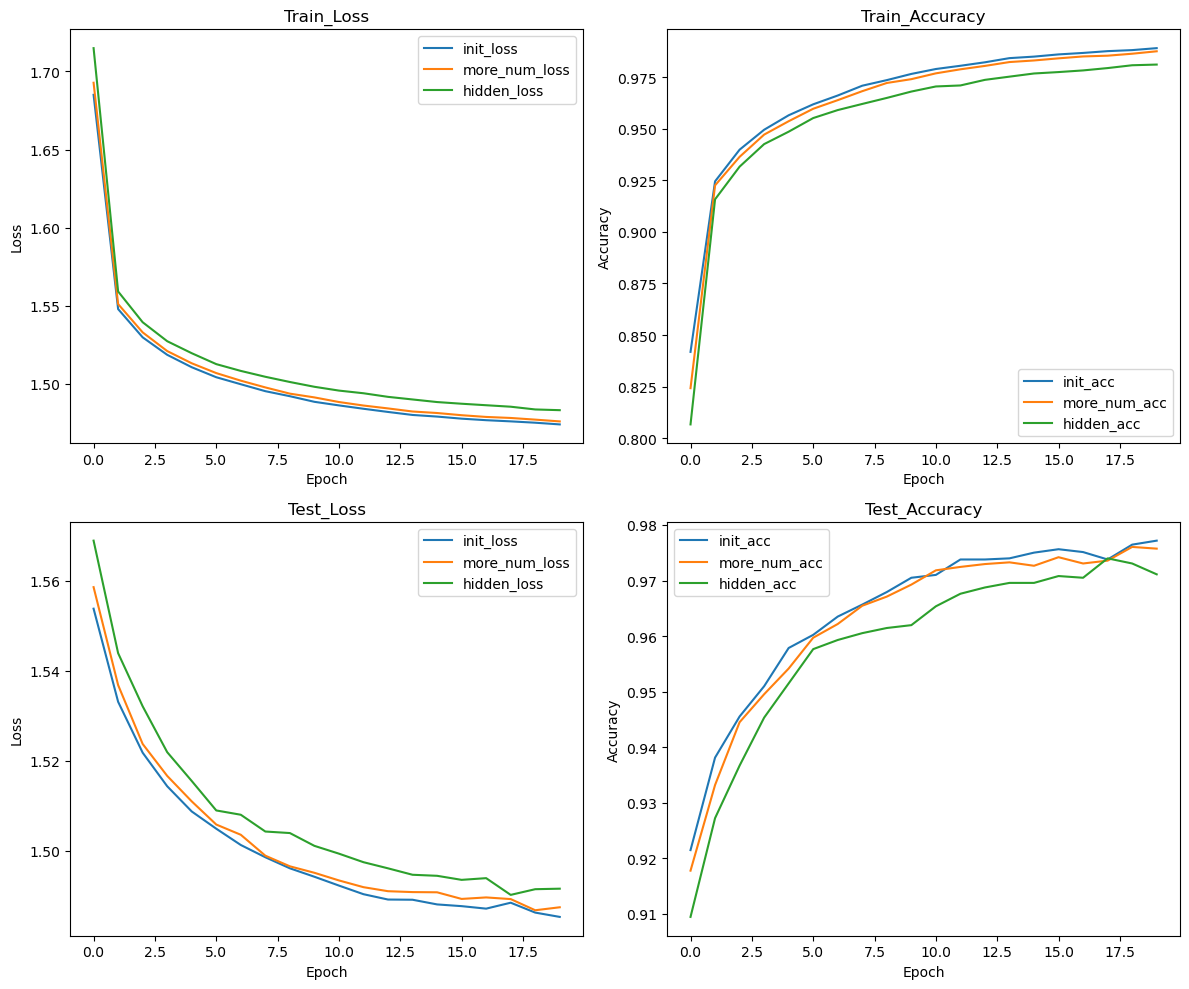

In [9]:
# 示例数据
train_loss = [train_loss_0, train_loss_1, train_loss_2]
test_loss = [test_loss_0, test_loss_1, test_loss_2]
train_acc = [train_acc_0, train_acc_1, train_acc_2]
test_acc = [test_acc_0, test_acc_1, test_acc_2]
titles_loss = ['Train_Loss', 'Test_Loss']
titles_acc = ['Train_Accuracy', 'Test_Accuracy']
labels = ['dropout=0', 'dropout=0.1', 'dropout=0.5']

# 创建2x2的图，并添加脚标
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 绘制Train_Loss和Test_Loss
for i in range(3):
    ax_train_loss = axes[0, 0]
    ax_train_loss.plot(train_loss[i], label=f'{labels[i]}')

    ax_test_loss = axes[1, 0]
    ax_test_loss.plot(test_loss[i], label=f'{labels[i]}')

# 绘制Train_Accuracy和Test_Accuracy
for i in range(3):
    ax_train_acc = axes[0, 1]
    ax_train_acc.plot(train_acc[i], label=f'{labels[i]}')

    ax_test_acc = axes[1, 1]
    ax_test_acc.plot(test_acc[i], label=f'{labels[i]}')

# 设置标题和标签
for ax in axes.flat:
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss' if ax in [axes[0, 0], axes[1, 0]] else 'Accuracy')

axes[0, 0].set_title(titles_loss[0])
axes[0, 0].legend()

axes[1, 0].set_title(titles_loss[1])
axes[1, 0].legend()

axes[0, 1].set_title(titles_acc[0])
axes[0, 1].legend()

axes[1, 1].set_title(titles_acc[1])
axes[1, 1].legend()

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
